In [1]:
import os
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import time



In [2]:

print(torch.version.cuda)
print(torch.backends.cuda.is_built())

12.6
True


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)


cuda


In [4]:
#RAHHH I LOVE TUTORIALS: https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html (thanks for the guide)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features,  weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, num_classes=2)
model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [5]:
print("Using device:", device)
print("Model lives on:", next(model.parameters()).device)

Using device: cuda
Model lives on: cuda:0


In [6]:
from helper import customCoco
from helper import collate

transform = transforms.Compose([
    transforms.ToTensor(),
])
    
X_train = "../data/license_plates/train/images"
y_train = "../data/license_plates/train/annotations.json"

train_dataset = customCoco(root=X_train, annFile=y_train, size=(128, 128), transform=transform)
#for the next one, try to make collate_fn work somehow so i can keep origional image size but its just not working for now
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True, collate_fn=collate)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [60.20338983050848, 90.4026402640264, 26.576271186440678, 13.518151815181518], 'area': 3136, 'segmentation': [], 'iscrowd': 0}]


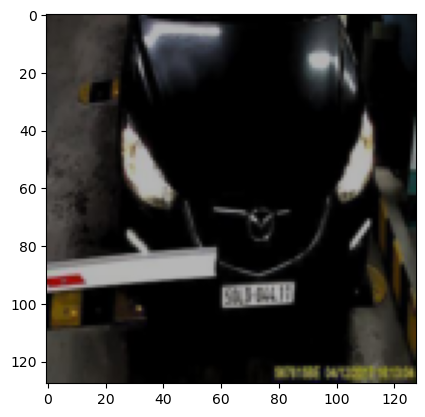

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, target = train_dataset[0]


fig, ax = plt.subplots(1)
ax.imshow(img.permute(1, 2, 0))  # Convert from [C,H,W] to [H,W,C]
print(target)

plt.show()

In [ ]:
#SKIP THIS STEP. mostly for when i was perma stuck on training with mps. switched to cpu instead for m3
loader = train_loader
t0 = time.time()
batch = next(iter(loader))
t1 = time.time()
print(f"Loaded 1 batch in {t1-t0:.2f}s")
imgs, targs = batch

t0 = time.time()
imgs_gpu = [img.to(device) for img in imgs]
for t in targs:
    t['boxes']  = t['boxes'].to(device)
    t['labels'] = t['labels'].to(device)
t1 = time.time()
print(f"Move→GPU: {t1-t0:.2f}s")
t0 = time.time()
_ = model(imgs_gpu, targs)
t1 = time.time()
print(f"Forward (single batch): {t1-t0:.2f}s")

Loaded 1 batch in 4.90s
Move→GPU: 0.01s


In [7]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-7
)


epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss   = 0.0
    i = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        for t in targets:
            t['boxes']  = t['boxes'].to(device)
            t['labels'] = t['labels'].to(device)
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        running_loss += loss_val
        epoch_loss   += loss_val

        if i % 50 == 0 or i == len(train_loader):
            print(f"[{epoch+1}/{epochs}, {i:5d}] "
                  f"loss/50 = {running_loss/50:.4f} | "
                  f"LR = {optimizer.param_groups[0]['lr']:.2e}")
            running_loss = 0.0
        i += 1
        
    scheduler.step(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1} finished - avg loss: {epoch_loss/len(train_loader):.4f}\n")

torch.save(model.state_dict(), "plate_model.pth")

[1/5,     0] loss/50 = 0.0064 | LR = 1.00e-04
[1/5,    50] loss/50 = 0.1106 | LR = 1.00e-04
[1/5,   100] loss/50 = 0.0997 | LR = 1.00e-04
[1/5,   150] loss/50 = 0.0936 | LR = 1.00e-04
[1/5,   200] loss/50 = 0.0827 | LR = 1.00e-04
[1/5,   250] loss/50 = 0.0925 | LR = 1.00e-04
[1/5,   300] loss/50 = 0.0949 | LR = 1.00e-04
[1/5,   350] loss/50 = 0.0851 | LR = 1.00e-04
[1/5,   400] loss/50 = 0.0991 | LR = 1.00e-04
[1/5,   450] loss/50 = 0.0807 | LR = 1.00e-04
[1/5,   500] loss/50 = 0.1004 | LR = 1.00e-04
[1/5,   550] loss/50 = 0.0771 | LR = 1.00e-04
[1/5,   600] loss/50 = 0.0957 | LR = 1.00e-04
[1/5,   650] loss/50 = 0.0738 | LR = 1.00e-04
[1/5,   700] loss/50 = 0.0852 | LR = 1.00e-04
[1/5,   750] loss/50 = 0.0885 | LR = 1.00e-04
[1/5,   800] loss/50 = 0.0782 | LR = 1.00e-04
[1/5,   850] loss/50 = 0.0688 | LR = 1.00e-04
[1/5,   900] loss/50 = 0.0819 | LR = 1.00e-04
[1/5,   950] loss/50 = 0.1021 | LR = 1.00e-04
[1/5,  1000] loss/50 = 0.0805 | LR = 1.00e-04
[1/5,  1050] loss/50 = 0.0841 | LR

In [8]:
X_test = "../data/license_plates/test/images"
y_test = "../data/license_plates/test/annotations.json"

test_dataset = customCoco(root=X_test, annFile=y_test, size=(128, 128), transform=transform)
#for the next one, try to make collate_fn work somehow so i can keep origional image size but its just not working for now
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True, collate_fn=collate)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [18]:
img, target = test_dataset[100]
model.eval()
with torch.no_grad():
    pred = model([img.to(device)])[0]

def area(t):
    x1, y1, x2, y2 = t.tolist()
    return (x2 - x1) * (y2 - y1)
    
print(max(pred['boxes'], key = lambda x: area(x)).tolist())

{'boxes': tensor([[32.2218, 65.6368, 62.5099, 80.4593],
        [11.6085, 24.4258, 20.2821, 30.6104],
        [13.0824, 17.1047, 19.9750, 28.0501],
        [13.5623, 21.2696, 20.7721, 32.4005],
        [12.5185, 18.4787, 19.7699, 23.8965],
        [12.7965, 26.2958, 20.7269, 31.9973],
        [12.1424, 20.3769, 19.6210, 26.4875],
        [14.0552, 23.3165, 21.5989, 29.0578],
        [10.9925, 22.2799, 18.6175, 33.2110],
        [13.4423, 12.6243, 19.7216, 23.9893],
        [10.8938, 22.9204, 19.6653, 28.3243],
        [13.8696, 24.7505, 21.0841, 35.6351],
        [11.5477, 15.3438, 18.2421, 26.5948],
        [ 9.7389, 24.6839, 17.3031, 36.3090],
        [12.8577, 19.3146, 17.5200, 22.8417],
        [11.1085, 14.3133, 18.6142, 21.8758]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7561, 0.1849, 0.1842, 0.1601, 0.1527, 0.1457, 0.1393, 0.1079, 0.1003,
        0.0956, 0.0769, 0.0674, 0.0669, 0.0636, 0.0603, 0.05

In [23]:
torch.save(model.module.state_dict(), "plate_model.pth")